In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

In [2]:
%matplotlib notebook

In [3]:
matplotlib.rcParams.update({'font.size': 15})

In [4]:
from attU.sql import psql_load

Eligibility techniques:

1) Naive search (type in a word and return things containing that) (maybe useful as helper tool as you go).  Could involve removing junk words or using IDF to identify junk words.  Or maybe swap synonyms into query.

2) Something like cosine-similarity for search?

3) LDA?

4) Binary eligible/ineligible prediction?  Maybe could give guidance like "we strongly recommend picking 'ineligible' for this one, human"


---- Other random questions ----

1) Any way to get Slack logs?

2) If we were to label some of these things, how would we store that?  Just a 2 column list of (ticket_id, outcome) pairs.

3) Are we properly merging chat and web stuff?  What is "web" exactly?

4) Any way to use broker attributes?  Could we tell if this is a broker's first quote?  Or if they are often abusing this process and always ask stupid stuff?

SC addition: Think about agent attributes/clustering as well.

## Load Data

In [5]:
df = pd.read_pickle('cleaned_eligibility_data')

9495 unique tickets for 12845 comments in our restricted set, removing 'chat ended' comments.

**Ignored**:  
ticket tags, requester tags, author tags  
account number, call duration, voice type, comment id, author name, author id

In [6]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...  
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...

In [693]:
df.t_created.max()

Timestamp('2019-09-19 21:58:13')

## Remove tickets that contain just macro responses or are follow ups to queries

Find tickets that don't contain timestamps, and from those find macros

In [95]:
df[df.comment_text.\
   map(lambda x: re.search(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)', x)).\
   isnull()].comment_text.str.contains('Thank you for contacting us\.').value_counts()

<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-95-7b701beb9c83>:3: DeprecationWarning: invalid escape sequence \.
  isnull()].comment_text.str.contains('Thank you for contacting us\.').value_counts()


True     1455
False     959
Name: comment_text, dtype: int64

In [7]:
df['text_type'] = df.comment_text.\
map(lambda x: re.search(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)', x)).\
map(lambda x: 'chat' if x else 'macro')

## Merge tickets

In [8]:
import string

In [9]:
#output one column
def preprocess_df_grp(grp):
    d = {}
    #merge comments for the same ticket id
    text = '\n'.join(grp['comment_text'])
    #remove timestamp/name
    text = re.sub(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)',
                  '', text)
    #remove names of agent or customer
    names = list(set(grp['a_name']).union(set(grp['r_name'])))
    #logic to get first and last names
    for n in names:
        split = n.split(' ')
        if len(split)>1:
            [names.append(s) for s in split]
    text = re.sub('|'.join(names),'',text)
    #remove punctuation
    text = re.sub(r"[{}]".format(string.punctuation),' ',text)
    #remove excess whitespace
    text = re.sub(' +', ' ',text).strip()
    
    d['cleaned'] = ' '.join([w.lower() for w in text.replace('\n','').split()])
    
    return pd.Series(d, index=['cleaned'])

Apply merge & preprocessing to 'chat' tickets only

In [10]:
merged_chat_comments = \
df[df.text_type=='chat'].groupby('t_id').apply(preprocess_df_grp)

In [11]:
#After dropping tickets that are just macros, how many ticket IDs contain multiple chats?
df[df.text_type=='chat'].groupby('t_id')['comment_text'].count().value_counts()

1    8688
2     678
3      87
4      21
5       6
6       2
Name: comment_text, dtype: int64

Spot check macro tickets

In [401]:
df[df.text_type=='macro'].comment_text[1]

'Hi Jeannie,\nThank you for contacting us. The class code for &lt;INSERT BUSINESS NAME&gt; is &lt;INSERT CLASS CODE HERE&gt;.\n[IF APPLICABLE: I have passed your feedback along to the appropriate teams at Attune.]\nYou can always reference the Attune Eligibility and Underwriting Guidelines in the Attune Portal to find the latest listing of all eligible class codes . Please don’t hesitate to reach out with any additional questions or concerns.'

Spot check sample (note chat names and database requester names are different)

In [290]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  \
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...   

  text_type  
0      chat  
1     macro

In [685]:
print(df.groupby('t_id')['comment_text'].agg(lambda x: '\n'.join(x)).iloc[1])

 
(07:27:59 PM) Donna: hi
(07:28:47 PM) David R.: Hi Donna! How are you today?
(07:28:52 PM) Donna: Hi David. I am well. How are you?
(07:29:22 PM) David R.: I'm also well! Thank you for asking
(07:29:51 PM) Donna: I was chatting with Ashl'Y M earlier today about a risk one of my agents is looking to bind. She was going to check on something and get back to me and I have not heard back.
(07:31:25 PM) Donna: I need to know if an account is eligible - it is a lessors risk only and the tenant is a dental office. They may do surgeries/sedation but my insured has nothing to do with those. My insured owns the building. Am I ok to bind coverage?
(07:35:14 PM) David R.: Ok! I do see that you were chatting with her earlier. I will just need a quick moment to check on this for you
(07:35:20 PM) Donna: Thank you!
(07:40:03 PM) David R.: Alright, can you confirm that the insured/business owner is not the tenant at this location?
(07:40:52 PM) Donna: yes, they are not the tenant. They are the build

In [292]:
merged_chat_comments.iloc[1]['cleaned']

'hi hi how are you today hi i am well how are you i m also well thank you for asking i was chatting with ashl y m earlier today about a risk one of my agents is looking to bind she was going to check on something and get back to me and i have not heard back i need to know if an account is eligible it is a lessors risk only and the tenant is a dental office they may do surgeries sedation but my insured has nothing to do with those my insured owns the building am i ok to bind coverage ok i do see that you were chatting with her earlier i will just need a quick moment to check on this for you thank you alright can you confirm that the insured business owner is not the tenant at this location yes they are not the tenant they are the building owner i am not looking to insure the dental office just the lessors risk exposure of the building ok since this is the case this risk is eligible for an l great when we enter it for gl do we still class it as a dental office what class should we use co

In [402]:
merged_chat_comments.head(2)

cleaned
t_id                                                     
100037  good afternoon good afternoon how are you toda...
100052  hi hi how are you today hi i am well how are y...

## Preprocessing and Tokenization

In [12]:
import spacy

//anaconda3/envs/zendesk/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
//anaconda3/envs/zendesk/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
//anaconda3/envs/zendesk/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
//anaconda3/envs/zendesk/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.

In [148]:
# !python -m spacy download en

In [13]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [19]:
# import nltk
# from gensim.utils import simple_preprocess

In [1099]:
# def token_stop(text):
#     #remove accents, keep words 2-15 chars, lower, remove stopwords
#     return [token for token in simple_preprocess(text, deacc=True) if token not in spacy.lang.en.stop_words.STOP_WORDS]
#     return tokens

In [43]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(text):
#     return [word for word in simple_preprocess(text) if word not in stop_words]

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

Update stop words

In [14]:
[i in spacy.lang.en.stop_words.STOP_WORDS for i in ['hi','good','hey','thank','morning','afternoon',
                                                    'evening','please','code','ok','great','welcome']]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False]

In [15]:
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [16]:
greetings = ['hi','good','hey','hello','thank','morning','afternoon',
             'evening','please','code','ok','great','welcome']
[spacy_stop_words.add(word) for word in greetings]
[word in spacy_stop_words for word in greetings]

[True, True, True, True, True, True, True, True, True, True, True, True, True]

Create docs

In [17]:
#remove spaces, stopwords (spacy), lemmatize, lower
def keep_token(t):
    
    return not (t.is_space or t.text in spacy_stop_words or len(t)<2 or len(t)>15)
#     return not (t.is_space or t.is_stop)

def lemmatize_doc(doc):
    return [t.lemma_ for t in doc if keep_token(t)]

In [18]:
# %%timeit -n1 -r1
docs = [lemmatize_doc(nlp(doc)) for doc in merged_chat_comments.cleaned.values]

In [19]:
print(df.groupby('t_id')['comment_text'].agg(lambda x: '\n'.join(x)).iloc[1])

 
(07:27:59 PM) Donna: hi
(07:28:47 PM) David R.: Hi Donna! How are you today?
(07:28:52 PM) Donna: Hi David. I am well. How are you?
(07:29:22 PM) David R.: I'm also well! Thank you for asking
(07:29:51 PM) Donna: I was chatting with Ashl'Y M earlier today about a risk one of my agents is looking to bind. She was going to check on something and get back to me and I have not heard back.
(07:31:25 PM) Donna: I need to know if an account is eligible - it is a lessors risk only and the tenant is a dental office. They may do surgeries/sedation but my insured has nothing to do with those. My insured owns the building. Am I ok to bind coverage?
(07:35:14 PM) David R.: Ok! I do see that you were chatting with her earlier. I will just need a quick moment to check on this for you
(07:35:20 PM) Donna: Thank you!
(07:40:03 PM) David R.: Alright, can you confirm that the insured/business owner is not the tenant at this location?
(07:40:52 PM) Donna: yes, they are not the tenant. They are the build

In [20]:
merged_chat_comments.cleaned.values[1]

'hi hi how are you today hi i am well how are you i m also well thank you for asking i was chatting with ashl y m earlier today about a risk one of my agents is looking to bind she was going to check on something and get back to me and i have not heard back i need to know if an account is eligible it is a lessors risk only and the tenant is a dental office they may do surgeries sedation but my insured has nothing to do with those my insured owns the building am i ok to bind coverage ok i do see that you were chatting with her earlier i will just need a quick moment to check on this for you thank you alright can you confirm that the insured business owner is not the tenant at this location yes they are not the tenant they are the building owner i am not looking to insure the dental office just the lessors risk exposure of the building ok since this is the case this risk is eligible for an l great when we enter it for gl do we still class it as a dental office what class should we use co

In [21]:
' '.join(docs[1])

'today ask chat ashl early today risk agent look bind go check hear need know account eligible lessor risk tenant dental office surgery sedation insure insure own building bind coverage chat earlier need quick moment check alright confirm insure business owner tenant location yes tenant building owner look insure dental office lessor risk exposure building case risk eligible enter gl class dental office class use correct dental office 63981 day feel free reach question'

### create text preprocessing introspection df

In [22]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  \
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...   

  text_type  
0      chat  
1     macro

In [23]:
merged_chat_ticket_processing = pd.DataFrame(df.groupby('t_id')['comment_text'].agg(lambda x: '\n'.join(x)))

In [24]:
merged_chat_ticket_processing['cleaned'] = merged_chat_comments.cleaned

In [25]:
merged_chat_ticket_processing.dropna(inplace=True)

In [26]:
merged_chat_ticket_processing['stop'] = [' '.join(d) for d in docs]

In [27]:
merged_chat_ticket_processing.head()

comment_text  \
t_id                                                        
100037   \n(07:09:37 PM) Susan : Good Afternoon\n(07:1...   
100052   \n(07:27:59 PM) Donna: hi\n(07:28:47 PM) Davi...   
100077   \n(07:53:06 PM) Ashley: Hello! I am having a ...   
100094   \n(08:01:53 PM) Drew Burks: Does Attune write...   
100130   \n(08:23:00 PM) Christina : Hello, please adv...   

                                                  cleaned  \
t_id                                                        
100037  good afternoon good afternoon how are you toda...   
100052  hi hi how are you today hi i am well how are y...   
100077  hello i am having a hard time classifying a ri...   
100094  does attune write for a virtual realty game bu...   
100130  hello please advise visitor uploaded 2 pdfu ht...   

                                                     stop  
t_id                                                       
100037  today want know entertain classcode 9028 wc qu...  
100052  today ask chat ashl early today risk agent loo...  
100077  have hard time classify risk want sure insure ...  
100094  attune write virtual realty game business fall...  
100130  advise visitor upload pdfu https v2uploads zop...

## TFIDF

### Sklearn

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
# data = [' '.join(d) for d in docs]
data = merged_chat_ticket_processing.stop.values

In [30]:
tfidf = TfidfVectorizer(max_df=.9, max_features=1000)
tfv = tfidf.fit_transform(data)

In [31]:
# tfidf.get_feature_names()

In [32]:
tfv[1].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0662241 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08734185, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.12389257, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

View top weight words by document by TFxIDF, or top words by IDF overall

In [518]:
#asc sorting of IDF weight index
idf_sorting =  tfidf.idf_.argsort()

In [519]:
tfidf.idf_[idf_sorting]

array([1.61050401, 1.78902696, 1.88162495, 1.93255644, 1.94062751,
       2.04352991, 2.09104843, 2.21276384, 2.24373498, 2.25884491,
       2.28441983, 2.41052309, 2.41702648, 2.44974381, 2.47800457,
       2.5209864 , 2.53508141, 2.56136608, 2.58269752, 2.58578235,
       2.59301753, 2.64846883, 2.66115866, 2.6672851 , 2.67064269,
       2.7106709 , 2.71887247, 2.72951716, 2.7366771 , 2.78200022,
       2.78325414, 2.81253695, 2.82423299, 2.82750631, 2.85005369,
       2.87587034, 2.87862706, 2.88624746, 2.92163686, 2.95162082,
       2.96733383, 2.96733383, 2.97794803, 3.00107936, 3.01601088,
       3.02396005, 3.03358322, 3.06717917, 3.10021902, 3.10280634,
       3.11496983, 3.11584434, 3.12728309, 3.13349705, 3.15692154,
       3.20261714, 3.24054098, 3.25451326, 3.26056167, 3.26056167,
       3.2758447 , 3.29345261, 3.3018472 , 3.31777956, 3.3188508 ,
       3.32746226, 3.33288233, 3.33614853, 3.35820014, 3.36603454,
       3.36828426, 3.36941102, 3.37733409, 3.40615453, 3.40732

In [520]:
np.array(tfidf.get_feature_names())[idf_sorting]

array(['help', 'thank', 'class', 'quote', 'today', 'risk',
       'unfortunately', 'moment', 'day', 'write', 'yes', 'problem',
       'eligible', 'sorry', 'need', 'store', 'okay', 'look', 'bop',
       'business', 'question', 'office', 'building', 'sure', 'don',
       'check', 'guideline', 'know', 'appetite', 'time', 'use', 'insure',
       'tenant', 'account', 'want', 'like', 'com', 'lro', 'ineligible',
       'able', 'correct', 'get', 'restaurant', 'attune', 'let', 'email',
       'try', 'happy', 'amp', 'location', 'work', 'retail', 'review',
       'confirm', 'fine', 'contact', 'think', 'feel', 'chat', 'care',
       'coverage', 'free', 'sell', 'service', 'rate', 'classification',
       'type', 'outside', 'decline', 'lessor', 'shop', 'ask', 'reach',
       'market', 'address', 'find', 'sale', 'will', 'new', 'rest', 'send',
       'provide', 'number', 'website', 'classify', 'exposure', 'https',
       'consider', 'occupy', 'underwriting', 'product', 'system', 'right',
       'advis

by document

In [33]:
tfidf.get_feature_names()[915]

'today'

In [34]:
tfidf.vocabulary_['today']

915

In [35]:
#sort tfidf vectors by doc descending, top n
features_array = np.array(tfidf.get_feature_names())

In [36]:
#get top n features and corresponding weights
n=10
top_n_tfidf_inds = np.fliplr(tfv.toarray().argsort(axis=1))[:,:n]
top_n_tfidf_weights = np.fliplr(np.sort(tfv.toarray(),axis=1))[:,:n]
top_n_tfidf_features = features_array[top_n_tfidf_inds]

In [37]:
top_n_tfidf_features

array([['ny', 'janitorial', 'classcode', ..., 'attach', 'wc', 'quick'],
       ['dental', 'insure', 'office', ..., 'owner', 'ashl', 'lessor'],
       ['food', 'inconvenience', 'hard', ..., 'have', 'see', 'specific'],
       ...,
       ['owner', 'lro', 'brooklyn', ..., 'building', 'ny', '10'],
       ['profit', 'non', 'organization', ..., 'answer', 'enjoy', 'come'],
       ['music', 'art', 'studio', ..., 'amp', 'able', 'ineligible']],
      dtype='<U15')

In [38]:
top_n_tfidf_weights

array([[0.33868369, 0.27006091, 0.25057886, ..., 0.21494629, 0.18746111,
        0.17913044],
       [0.56645843, 0.26349397, 0.24812317, ..., 0.17954347, 0.1607039 ,
        0.15767434],
       [0.35138469, 0.26743276, 0.26334641, ..., 0.21571868, 0.2151303 ,
        0.21322189],
       ...,
       [0.30546076, 0.23001801, 0.21298637, ..., 0.15902658, 0.15654966,
        0.15440764],
       [0.4819728 , 0.36304465, 0.26062326, ..., 0.18830404, 0.16241847,
        0.16234063],
       [0.5296542 , 0.50875012, 0.45252782, ..., 0.13504277, 0.12856996,
        0.12726389]])

### Gensim 

In [981]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

//anaconda3/envs/zendesk/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
//anaconda3/envs/zendesk/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [1047]:
#create mapping between words and integer IDs
#https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary
docs_dict = Dictionary(docs)

In [1076]:
print(docs_dict)

Dictionary(28284 unique tokens: ['9028', 'afternoon', 'appetite', 'attach', 'attribute']...)


In [50]:
# sorted([(docs_dict[k],v) for k,v in docs_dict.dfs.items()], key=lambda x: x[1], reverse=True)

In [52]:
# [(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

In [ ]:
# docs_dict.filter_extremes(no_below=20, no_above=0.2)
# docs_dict.compactify()

In [1049]:
#convert each doc to BOW rep (counts of word IDs per doc)
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]

In [53]:
# docs_corpus[0]

In [1051]:
#transform  bow vectors to tfidf vectors
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]

In [1054]:
#view sample
[(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

[('dental', 0.5803287266730481),
 ('insuredbusiness', 0.26154100149465176),
 ('surgeriessedation', 0.26154100149465176),
 ('earlier', 0.25008827112587595),
 ('63981', 0.16536743993664402),
 ('owner', 0.16519462849918568),
 ('insure', 0.1640982076570375),
 ('ashly', 0.16346266312623767),
 ('bind', 0.1631676734607926),
 ('tenant', 0.15630612124484414),
 ('lessor', 0.14531138445969344),
 ('office', 0.1428583241502388),
 ('building', 0.14190627879127143),
 ('offices', 0.14102735953469592),
 ('chat', 0.12192079215897975),
 ('alright', 0.12102109700017323),
 ('risk', 0.11745236143687482),
 ('m', 0.10788539312817073),
 ('own', 0.09999984085607022),
 ('enter', 0.09769837618370808),
 ('check', 0.09685718175839256),
 ('hear', 0.09256795844007877),
 ('gl', 0.09158430130080662),
 ('case', 0.08999314692542257),
 ('quick', 0.08957415065422689),
 ('ok', 0.08913850038157992),
 ('look', 0.08887368137877899),
 ('need', 0.0838487173558619),
 ('eligible', 0.07770756042948618),
 ('go', 0.07712877123968771)

In [1055]:
#convert vectors in bow format to dense vectors dim n_doc x len_dict
docs_vecs  = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [1063]:
docs_vecs

array([[0.4047528 , 0.21239552, 0.07665578, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09729766, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1572759 , 0.3145518 ,
        0.3145518 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [1059]:
docs_vecs.shape

(9483, 28284)

### KNN with cosine

In [39]:
from sklearn.neighbors import NearestNeighbors

In [40]:
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfv)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [41]:
top_n_tfidf_features[0]

array(['ny', 'janitorial', 'classcode', 'class', 'noc', 'clarify',
       'entertain', 'attach', 'wc', 'quick'], dtype='<U15')

In [42]:
print('\x1b[1;03;30;43m'+'Hello'+'\x1b[0m')

Hello


In [45]:
dist, inds =  nn.kneighbors(tfv[4])
for i, d in enumerate(dist[0]):
    print('--------------------'+' Distance: {:.3f}'.format(d))
    text = merged_chat_ticket_processing.comment_text.iloc[inds[0][i]]
    for keyword in top_n_tfidf_features[inds[0][i]]:
        text = text.replace(keyword,'\x1b[1;03;30;43m'+keyword+'\x1b[0m')
    print(text)

-------------------- Distance: 0.000
 
(08:23:00 PM) Christina : Hello, please advise
(08:24:09 PM) Christina : Visitor uploaded: 2.pdf
URL: https://v2uploads.zopim.io/q/i/H/qiHTbmp82RwzdOJy2irGfdTs893cHXHI/c84e93be96f6952ff38a1bdd47325699f98c9a1e.pdf
Type: application/pdf
Size: 462179
(08:25:07 PM) Christina : Please advise in regards of the attached Kingstone is cancelling 06/04/2019
(08:25:27 PM) Christina : per attachment: Does not meet company guidelines
(08:25:48 PM) Christina : Per Broker is Being cancelled with Kingstone 06/04/2019 because they sublease their office from a florist.
(08:25:52 PM) Christina : Please advise
(08:26:05 PM) Christina : If we can quote captioned risk in attune
(08:33:06 PM) David R.: Hi Christina! How are you today?
(08:35:38 PM) David R.: Can you give me a quick moment to look through this for you?
(08:37:28 PM) David R.: Could you please provide more information on this risk?
(08:40:01 PM) David R.: Are you still with me Christina?
(08:41:44 PM) Chr

## Kmeans on TFIDF

In [666]:
from sklearn.cluster import KMeans

In [682]:
# Sum_of_squared_distances = []
K = range(70,111,20)

for k in K:
    time_start = time.time()
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=300)
    km = km.fit(tfv)
    Sum_of_squared_distances.append(km.inertia_)
    print('kmeans {} done! Time elapsed: {} seconds'.format(k,time.time()-time_start))

kmeans 70 done! Time elapsed: 83.62015056610107 seconds
kmeans 90 done! Time elapsed: 74.06711769104004 seconds
kmeans 110 done! Time elapsed: 76.81947302818298 seconds


In [683]:
plt.plot([5,10,15,20,25,30,35,40,50,60,70,90,110], Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<IPython.core.display.Javascript object>

widget visualization for cluster content

In [ ]:
#preprocess, tokenize (bigrams, trigrams, vectorize, transform (tfidf, lsi, lda), cluster/classify

### Evaluation of clusters

## Other Embeddings

## Labeling with macros

In [700]:
tcdf = df[df.comment_text.str.contains('Thank you for contacting us')].copy()

In [701]:
def phrase_label(text):
    
    e = ['Yes, we currently write', 'The class code for']
    ne = ['currently do not write', 'not an eligible class', 'nfortunately']
    
    if any([phrase in text for phrase in e]):
        return 'eligible'
    elif any([phrase in text for phrase in ne]):
        return 'not eligible'
    elif 'reason you were declined' in text:
        return 'declined'
    else:
        return None

In [702]:
#count nulls
tcdf['label'] = tcdf.comment_text.map(phrase_label)

In [703]:
tcdf.head()

t_id           t_created                r_name          r_id  \
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
5  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
7  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   
9  148925 2019-09-19 21:19:42     Vincent Mosomillo  363659707672   

           a_id    a_name                     subject  \
1  374984390592  Shane C.           Chat with Jeannie   
3  374984390592  Shane C.            Chat with denise   
5  374984390592  Shane C.         Chat with jeff wolf   
7  374984390592  Shane C.    Chat with georgette diaz   
9  374984390592  Shane C.  Chat with Vncent Mosomillo   

                                        comment_text text_type         label  
1  Hi Jeannie,\nThank you for contacting us. The ...     macro      eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...     macro  not eligible  
5  Hi Jeffrey,\nThank you for contacting us.\nYes...     macro      eligible  
7  Hi Georgette,\nThank you for contacting us.\nA...     macro  not eligible  
9  Hi Vincent,\nThank you for contacting us.\nAt ...     macro  not eligible

In [704]:
tcdf.label.isnull().sum()

112

In [705]:
tcdf.label.value_counts()

not eligible    844
eligible        463
declined         64
Name: label, dtype: int64

Check distributions of macro responses vs general chat

In [514]:
# df.drop('label',axis=1,inplace=True)

In [12]:
df['text'] = df.comment_text.str.contains('Thank you for contacting us').map(lambda x: 'macro' if x else 'chat')

In [532]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

<IPython.core.display.Javascript object>


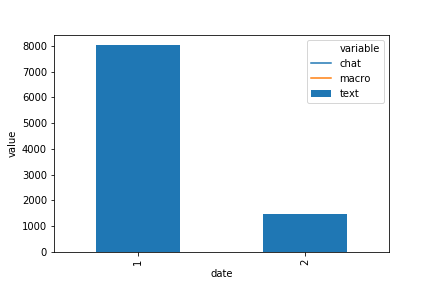

In [553]:
#number of tickets that include macro responses for labeling
df.groupby('t_id')['text'].nunique().value_counts().plot.bar()

In [554]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

In [559]:
ttdf = df[['t_created','text']].copy()

In [572]:
ttdf['date'] = ttdf.t_created.map(lambda x: x.date())

In [616]:
ts = ttdf.groupby(['date','text']).count().unstack(fill_value=0)

In [630]:
ts.columns = ['chat','macro']

In [632]:
ts.head()

chat  macro
date                   
2018-02-16     1      0
2018-02-20    18      0
2018-02-21    10      1
2018-02-22    14      1
2018-02-23    10      0

In [643]:
#long form for seaborn plotting
ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']).head()

date variable  value
0  2018-02-16     chat      1
1  2018-02-20     chat     18
2  2018-02-21     chat     10
3  2018-02-22     chat     14
4  2018-02-23     chat     10

Number of tickets per day that have macro responses. Ideal would be all?

<IPython.core.display.Javascript object>


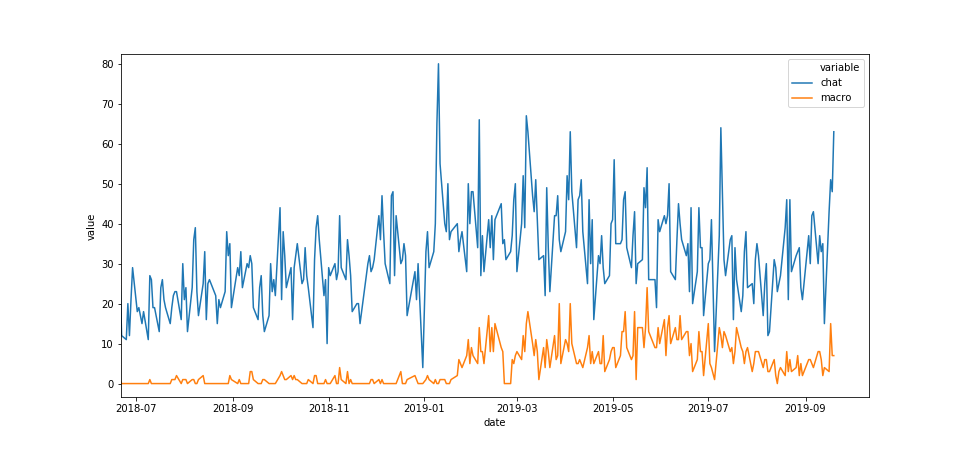

In [646]:
fig, ax= plt.subplots()
sns.lineplot(x='date', y='value',hue='variable',
             data=ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']),ax=ax)

Apply template phrases to larger dataset (need to verify accuracy of phrases)

In [447]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text         label  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...          None  
1  Hi Jeannie,\nThank you for contacting us. The ...      eligible  
2   \n(09:22:45 PM) denise: Do you allow electric...  not eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...  not eligible  
4   \n(09:21:52 PM) jeff wolf: what is best class...  not eligible

In [415]:
df['label'] = df.comment_text.map(phrase_label)

In [422]:
df.label.value_counts()/12845

not eligible    0.325963
eligible        0.036902
declined        0.005216
Name: label, dtype: float64

In [455]:
print(df[df.label=='not eligible'].comment_text[16])

 
(08:26:38 PM) Michelle Lee: Good Afternoon
I have a risk that is a lessors Risk
they have 2 Whole sales tenants - one is Jewelry and the other is a camera distributor
can we entertain this risk?
(08:27:30 PM) Michelle Lee: Hi Ashl'Y
(08:28:17 PM) Ashl'Y M.: hey Michelle the jewelry wholesale is okay
(08:28:24 PM) Ashl'Y M.: let me check on the camera
(08:28:26 PM) Ashl'Y M.: One moment please
(08:28:28 PM) Michelle Lee: thank you
(08:33:06 PM) Ashl'Y M.: how much space does the camera occupy
(08:33:54 PM) Michelle Lee: the total sq ft for the building is 10,000
Jewelry - 7,000
Camera Distributor - 3,000
(08:37:34 PM) Ashl'Y M.: okay unfortunately we wouldnt be able to write this because of the camera
(08:37:42 PM) Michelle Lee: thank you for trying
(08:37:44 PM) Michelle Lee: have a great day
(08:37:51 PM) Ashl'Y M.: you as well

